In [23]:
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import geojson
import rasterio
import pygmsh
import firedrake
from firedrake import Constant, sqrt, inner, grad, dx
import icepack
from icepack.constants import (
    ice_density as ρ_I, gravity as g, weertman_sliding_law as m
)

In [24]:

outline_filename = "../mesh/amundsen.geojson"
with open(outline_filename, "r") as outline_file:
    outline = geojson.load(outline_file)

geometry = icepack.meshing.collection_to_geo(outline)
with open("../mesh/amundsen.geo", "w") as geo_file:
    geo_file.write(geometry.get_code())
    

In [25]:

command = "gmsh -2 -format msh2 -v 2 -o ../mesh/amundsen.msh ../mesh/amundsen.geo"
subprocess.run(command.split(" "))

mesh = firedrake.Mesh("../mesh/amundsen.msh")



In [26]:
coords = np.array(list(geojson.utils.coords(outline)))
delta = 30e3
xmin, xmax = coords[:, 0].min() - delta, coords[:, 0].max() + delta
ymin, ymax = coords[:, 1].min() - delta, coords[:, 1].max() + delta

In [27]:
image_filename = icepack.datasets.fetch_mosaic_of_antarctica()
with rasterio.open(image_filename, "r") as image_file:
    height, width = image_file.height, image_file.width
    transform = image_file.transform
    window = rasterio.windows.from_bounds(
        left=xmin,
        bottom=ymin,
        right=xmax,
        top=ymax,
        transform=transform,
    )
    image = image_file.read(indexes=1, window=window, masked=True)


In [55]:
def subplots(*args, **kwargs):
    fig, axes = plt.subplots()
    axes.set_aspect("equal")
    xmin, ymin, xmax, ymax = rasterio.windows.bounds(window, transform)
    axes.imshow(
        image,
        cmap="Greys_r",
        vmin=12e3,
        vmax=19.38e3,
        extent=(xmin, xmax, ymin, ymax),
    )
    axes.tick_params(labelrotation=25)

    return fig, axes


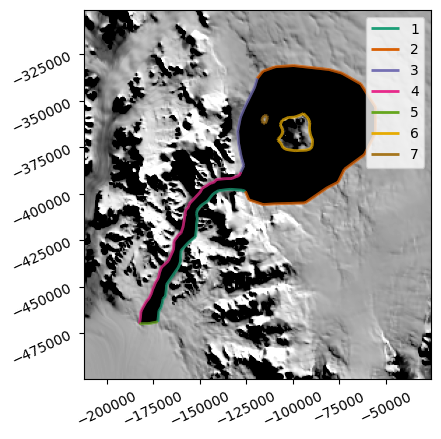

In [56]:


fig, axes = subplots()
kwargs = {
    "interior_kw": {"linewidth": 0.25},
    "boundary_kw": {"linewidth": 2},
}
firedrake.triplot(mesh, axes=axes, **kwargs)
axes.legend()

In [30]:
Q = firedrake.FunctionSpace(mesh, family="CG", degree=2)
V = firedrake.VectorFunctionSpace(mesh, family="CG", degree=2)

In [31]:
bedmachine_filename = icepack.datasets.fetch_bedmachine_antarctica()
thickness_filename = f"netcdf:{bedmachine_filename}:thickness"
with rasterio.open(thickness_filename, "r") as thickness_file:
    h = icepack.interpolate(thickness_file, Q)
    
bed_filename = f"netcdf:{bedmachine_filename}:bed"
with rasterio.open(bed_filename, "r") as bed_file:
    bed = icepack.interpolate(bed_file, Q)

In [32]:
s = firedrake.interpolate(h+bed,Q)

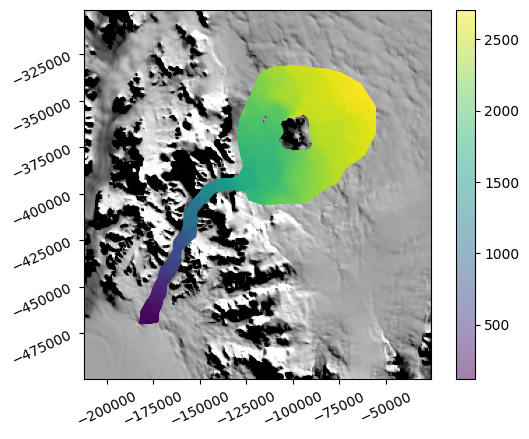

In [59]:
fig, axes = subplots()
colors = firedrake.tripcolor(s, axes=axes,alpha=.5)
fig.colorbar(colors);


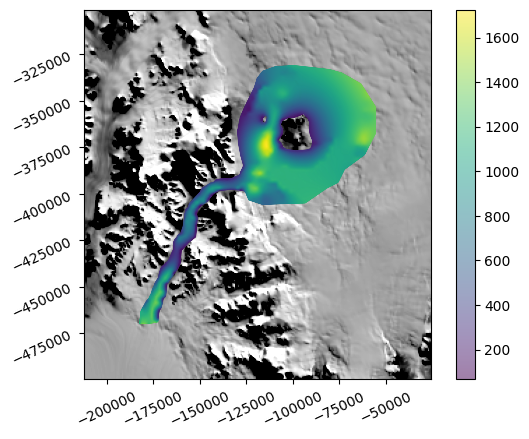

In [60]:


fig, axes = subplots()
colors = firedrake.tripcolor(h, axes=axes,alpha=.5)
fig.colorbar(colors);



In [35]:


measures_filename = icepack.datasets.fetch_measures_antarctica()
with rasterio.open(f"netcdf:{measures_filename}:VX", "r") as vx_file, \
     rasterio.open(f"netcdf:{measures_filename}:VY", "r") as vy_file:
    u_obs = icepack.interpolate((vx_file, vy_file), V)



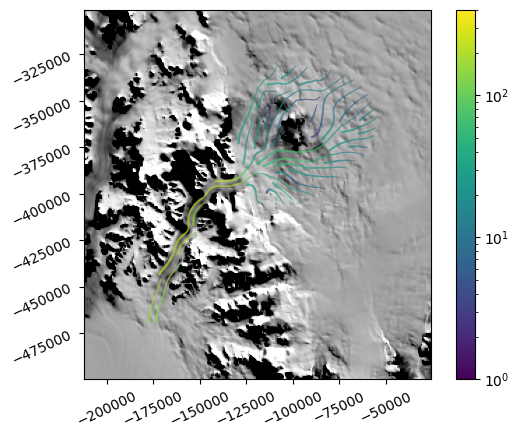

In [61]:


log_norm = matplotlib.colors.LogNorm(vmin=1.0, vmax=400.0)

fig, axes = subplots()
streamlines = firedrake.streamplot(
    u_obs, norm=log_norm, axes=axes, resolution=2.5e3, seed=1729
)
fig.colorbar(streamlines);



In [37]:
α = Constant(10e3)
τ = firedrake.Function(V)
τ_d = -ρ_I * g * h * grad(s)
misfit = 0.5 * inner(τ - τ_d, τ - τ_d) * dx
smoothness = 0.5 * α ** 2 * inner(grad(τ), grad(τ)) * dx
J = misfit + smoothness
F = firedrake.derivative(J, τ)
firedrake.solve(F == 0, τ)

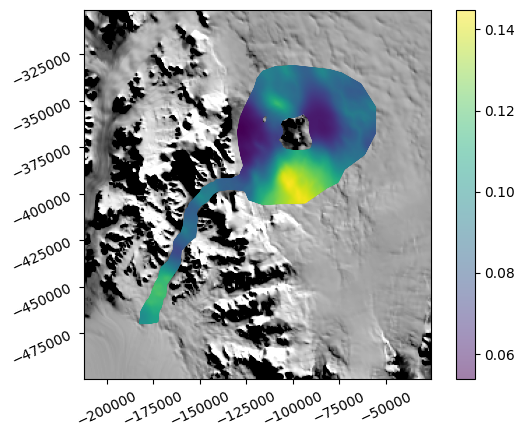

In [62]:


fig, axes = subplots()
colors = firedrake.tripcolor(τ, axes=axes,alpha=.5)
fig.colorbar(colors);



In [39]:
fraction = Constant(0.5)
expr = fraction * sqrt(inner(τ, τ)) / sqrt(inner(u_obs, u_obs)) ** (1 / m)
C = firedrake.interpolate(expr, Q)
area = firedrake.assemble(Constant(1.0) * dx(mesh))
C_0 = Constant(firedrake.assemble(C * dx) / area)

In [40]:
T = Constant(260.0)
A = icepack.rate_factor(T)


In [41]:


def friction(**kwargs):
    u = kwargs["velocity"]
    θ = kwargs["log_friction"]
    C = C_0 * firedrake.exp(θ)
    return icepack.models.friction.bed_friction(velocity=u, friction=C)



In [42]:


model = icepack.models.IceStream(friction=friction)
opts = {
    "dirichlet_ids": [1, 2, 3, 4, 5, 6,7],
    "diagnostic_solver_type": "petsc",
    "diagnostic_solver_parameters": {
        "snes_type": "newtontr",
        "ksp_type": "gmres",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
}
solver = icepack.solvers.FlowSolver(model, **opts)



In [43]:


θ = firedrake.Function(Q)



In [44]:


u = solver.diagnostic_solve(
    velocity=u_obs,
    thickness=h,
    surface=s,
    fluidity=A,
    log_friction=θ,
)



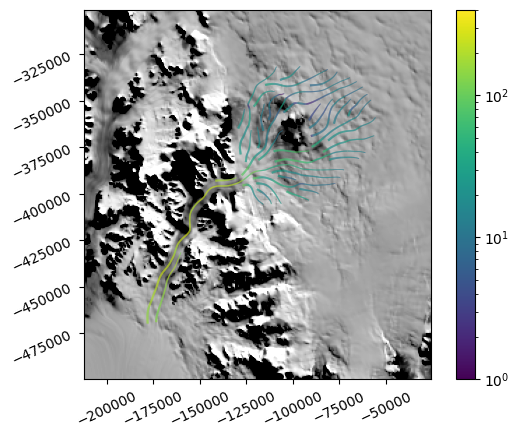

In [64]:
fig, axes = subplots()
streamlines = firedrake.streamplot(
    u, norm=log_norm, axes=axes, resolution=2.5e3, seed=1729
)
fig.colorbar(streamlines);

In [46]:


def simulation(θ):
    return solver.diagnostic_solve(
        velocity=u_obs,
        thickness=h,
        surface=s,
        fluidity=A,
        log_friction=θ,
    )

σx = Constant(5.0)
σy = Constant(5.0)
def loss_functional(u):
    δu = u - u_obs
    return 0.5 / Constant(area) * ((δu[0] / σx)**2 + (δu[1] / σy)**2) * dx

L = Constant(10e3)
def regularization(θ):
    return 0.5 * L**2 / Constant(area) * inner(grad(θ), grad(θ)) * dx



In [47]:


from icepack.statistics import StatisticsProblem, MaximumProbabilityEstimator

problem = StatisticsProblem(
    simulation=simulation,
    loss_functional=loss_functional,
    regularization=regularization,
    controls=θ,
)



In [48]:


estimator = MaximumProbabilityEstimator(
    problem,
    gradient_tolerance=1e-4,
    step_tolerance=1e-1,
    max_iterations=50,
)
θ = estimator.solve()




Truncated CG Trust-Region Solver
  iter  value          gnorm          snorm          delta          #fval     #grad     tr_flag   iterCG    flagCG    
  0     1.260200e+03   1.841273e-01                  7.037564e+03   
  1     4.538866e+02   6.471060e-02   7.037564e+03   1.759391e+04   3         2         0         1         3         
  2     1.409351e+02   3.410522e-02   1.759391e+04   4.398478e+04   4         3         0         4         2         
  3     1.409351e+02   3.410522e-02   4.398478e+04   2.749049e+03   5         3         2         9         2         
  4     8.630862e+01   1.850616e-02   2.749049e+03   6.872622e+03   6         4         0         2         3         
  5     3.456315e+01   7.489831e-03   6.872622e+03   1.718155e+04   7         5         0         6         3         
  6     1.255484e+01   6.058568e-03   1.533103e+04   4.295388e+04   8         6         0         20        1         
  7     6.083662e+00   2.173086e-03   5.805835e+03   1.073847e+0

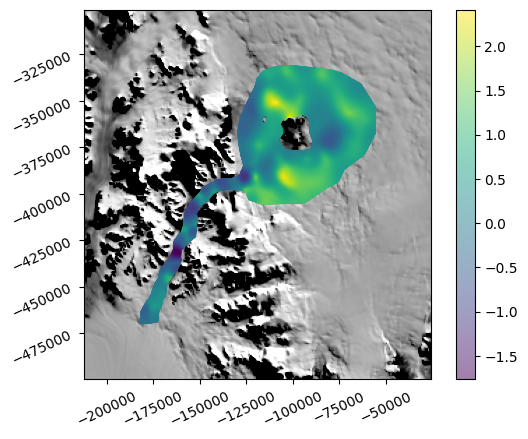

In [63]:
fig, axes = subplots()
colors = firedrake.tripcolor(θ, axes=axes,alpha=.5)
fig.colorbar(colors);

In [50]:
u = simulation(θ)

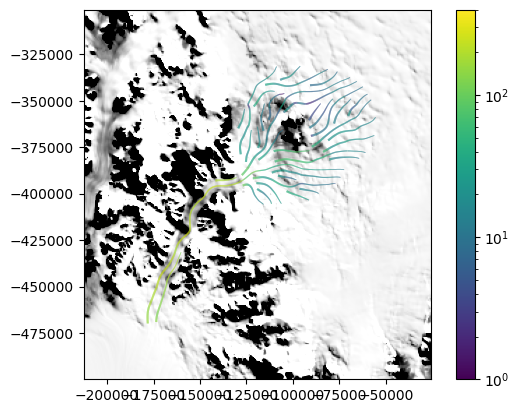

In [51]:


fig, axes = subplots()
streamlines = firedrake.streamplot(
    u, norm=log_norm, axes=axes, resolution=2.5e3, seed=1729
)
fig.colorbar(streamlines);



In [52]:
δu = firedrake.interpolate(sqrt(inner(u - u_obs, u - u_obs)), Q)

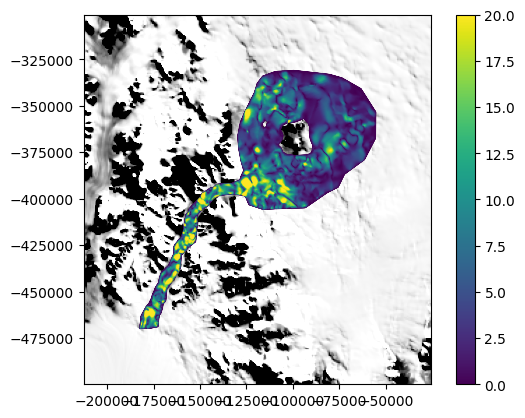

In [53]:


fig, axes = subplots()
colors = firedrake.tripcolor(δu, vmin=0.0, vmax=20.0, axes=axes)
fig.colorbar(colors);



In [71]:


C = firedrake.interpolate(C_0 * firedrake.exp(θ), Q)
filename = "../data/modern_state.h5"
with firedrake.CheckpointFile(filename, "w") as chk:
    chk.save_mesh(mesh)
    chk.save_function(C, name="friction")
    chk.save_function(u, name="velocity")
    chk.save_function(h, name="thickness")
    chk.save_function(bed, name = "bed")


